<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> Procesamiento de Lenguaje Natural 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 9:</strong> Reconocimiento de Voz Simple vs
Whisper-tiny</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autor:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
      </ul>
    </td>
  </tr>
</table>

# Ejercicio 1

### Explique la diferencia entre el espectrograma lineal y el log-mel, y por qué este último es preferible en modelos de ASR.

El espectrograma lineal muestra la energía del audio en una escala de frecuencias uniforme (Hz), útil para análisis físico pero poco representativa de la audición humana. En cambio, el log-Mel spectrograma usa una escala perceptual (Mel) y logarítmica que refleja cómo percibimos las frecuencias y la intensidad del sonido. De esta forma, es preferible en ASR porque reduce la dimensionalidad, se centra en las zonas donde el oído humano distingue mejor los fonemas y hace al modelo más robusto a ruido y a variaciones de volumen.

Librerías

In [1]:
from torch.utils.data import DataLoader
from datasets import load_dataset, Audio
from tqdm.auto import tqdm
from jiwer import wer
import re
import os
import io
import time
import torch
import librosa
import librosa
import whisper
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

c:\Users\daher\Documents\SEMESTRE10\NLP\NLP-ASR-TTS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carga del dataset

In [2]:
VOCAB_STR = " 'ABCDEFGHIJKLMNOPQRSTUVWXYZ"
BLANK = 0
CHAR_TO_IDX = {c: i+1 for i, c in enumerate(VOCAB_STR)}  # 1..len
IDX_TO_CHAR = {i+1: c for i, c in enumerate(VOCAB_STR)}
VOCAB_SIZE = len(VOCAB_STR) + 1

def text_clean(s: str) -> str:
    s = s.strip().upper()
    s = re.sub(r"[^ A-Z']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def text_to_indices(s: str):
    s = text_clean(s)
    return [CHAR_TO_IDX[c] for c in s if c in CHAR_TO_IDX]

def indices_to_text(ids):
    return "".join(IDX_TO_CHAR.get(i, "") for i in ids)

print("SIZE:", VOCAB_SIZE, "| BLANK:", BLANK)

SIZE: 29 | BLANK: 0


In [3]:
dataset = load_dataset("librispeech_asr", "clean", split="train.100")
dataset = dataset.cast_column("audio", Audio(decode=False))
sample = max(1, len(dataset) // 200) # type: ignore
dataset = dataset.select(range(sample)) # type: ignore
print(f"Muestras en subset: {len(dataset)}")

Muestras en subset: 142


In [4]:
SR = 16000
N_MELS = 80
HOP = 160
FFT = 400

def extract_logmel_features(batch):
    """
    Convierte los audios de un batch de LibriSpeech en log-mel spectrograms.
    - Usa librosa para leer directamente desde los bytes.
    - Devuelve matrices [frames, n_mels].
    - Aplica text_clean a las transcripciones.
    """
    feats, texts = [], []
    for audio_info, transcript in zip(batch["audio"], batch["text"]):
        # Cargar el audio desde los bytes
        signal, sr = librosa.load(io.BytesIO(audio_info["bytes"]), sr=SR)

        # Generar espectrograma Mel
        mel_spec = librosa.feature.melspectrogram(
            y=signal,
            sr=sr,
            n_fft=FFT,
            hop_length=HOP,
            n_mels=N_MELS,
            power=2.0,
        )

        # Convertir a escala logarítmica (dB)
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)

        # Transponer a [frames, n_mels] (útil para el Transformer)
        log_mel = log_mel.T.astype(np.float32)

        feats.append(log_mel.tolist())
        texts.append(text_clean(transcript))

    return {"logmel": feats, "transcript": texts}


# Aplicar al dataset
processed_dataset = dataset.map(
    extract_logmel_features,
    batched=True,
    batch_size=8,
    remove_columns=["audio"],
)

print("Ejemplo de texto:", processed_dataset[0]["transcript"]) # type: ignore
print("Forma del logmel:", np.array(processed_dataset[0]["logmel"]).shape) # type: ignore


Ejemplo de texto: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Forma del logmel: (1454, 80)


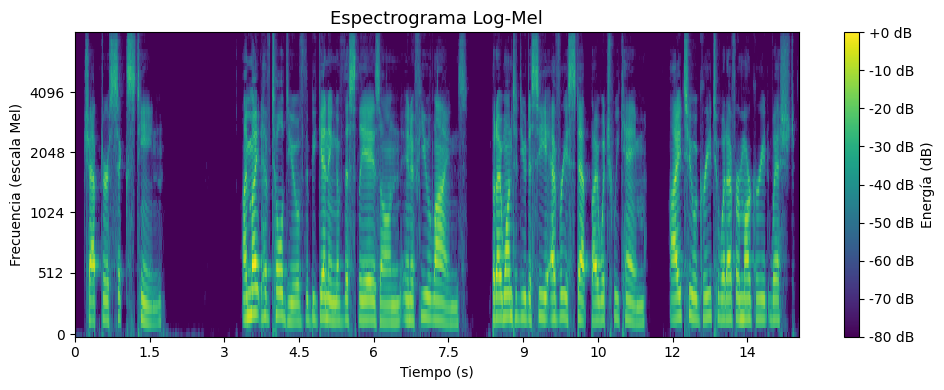

Eje X (temporal): 1454 frames ≈ 14.54 segundos
Eje Y (frecuencial): 80 bandas Mel
Resolución temporal: 10.0 ms por frame
Resolución espectral (ventana FFT): 25.0 ms


In [5]:
sample_mel = np.array(processed_dataset[0]["logmel"]) # type: ignore
frames, n_mels = sample_mel.shape

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    sample_mel.T,
    sr=SR,
    hop_length=HOP,
    x_axis="time",
    y_axis="mel",
    fmax=8000,
    cmap="viridis"
)
plt.title("Espectrograma Log-Mel", fontsize=13)
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (escala Mel)")
cbar = plt.colorbar(format="%+2.0f dB")
cbar.set_label("Energía (dB)")
plt.tight_layout()
plt.show()  

duracion_seg = frames * HOP / SR
print(f"Eje X (temporal): {frames} frames ≈ {duracion_seg:.2f} segundos")
print(f"Eje Y (frecuencial): {n_mels} bandas Mel")
print(f"Resolución temporal: {HOP/SR*1000:.1f} ms por frame")
print(f"Resolución espectral (ventana FFT): {FFT/SR*1000:.1f} ms")


### *Visualice la matriz log-mel como un mapa de calor e interprete el eje temporal y frecuencial.*

El mapa de calor del espectrograma log-Mel muestra la energía del audio en función del tiempo (eje X) y la frecuencia perceptual (eje Y). Por un lado en el eje X, se representa la evolución temporal del sonido, con 1454 frames ≈ 14.54 segundos, donde cada frame equivale a 10 ms. Las variaciones horizontales reflejan los cambios de intensidad y estructura del habla a lo largo del tiempo. En cambio, el eje Y corresponde a las 80 bandas Mel, que resumen el contenido frecuencial en una escala perceptual. Las zonas inferiores contienen frecuencias bajas, mientras que las superiores capturan componentes más agudas del habla. Los colores de la gráfica muestran la energía en decibelios (dB): tonos amarillos representan mayor energía (sonidos fuertes o vocales), y los azules oscuros, casi morados, menor energía (silencios o consonantes suaves). De esta forma, este espectrograma muestra cómo la energía del habla varía tanto en el tiempo como en las frecuencias perceptuales relevantes para el reconocimiento de voz.

# Ejercicio 2

In [ ]:
def prepare_example(ex):
    """
    Convierte un ejemplo del processed_dataset en tensores:
      - logmel: [T, 80]
      - target: índices de caracteres (CTC)
    """
    mel = torch.tensor(ex["logmel"], dtype=torch.float32)      # [T, 80]
    target = torch.tensor(text_to_indices(ex["transcript"]),   # [L]
                          dtype=torch.long)
    return mel, target

def collate_ctc(batch):
    """
    Junta secuencias de distinta longitud para CTCLoss.
    batch: lista de (mel[T_i, 80], target[L_i])
    """
    mels, targets = zip(*batch)

    input_lengths  = torch.tensor([m.shape[0] for m in mels], dtype=torch.long)
    target_lengths = torch.tensor([t.shape[0] for t in targets], dtype=torch.long)

    B = len(mels)
    T_max = int(input_lengths.max())
    F = mels[0].shape[1]

    x_padded = torch.zeros(B, T_max, F, dtype=torch.float32)
    for i, m in enumerate(mels):
        x_padded[i, :m.shape[0]] = m

    targets_concat = torch.cat(targets, dim=0)

    return x_padded, input_lengths, targets_concat, target_lengths

# Split train/valid
splits = processed_dataset.train_test_split(test_size=0.2, seed=42) # type: ignore
train_ds = splits["train"]
valid_ds = splits["test"]

BATCH_SIZE = 4

train_loader = DataLoader(
    train_ds, # type: ignore
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda batch: collate_ctc([prepare_example(ex) for ex in batch]),
)

valid_loader = DataLoader(
    valid_ds, # type: ignore
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda batch: collate_ctc([prepare_example(ex) for ex in batch]),
)

x_batch, in_len_batch, y_batch, y_len_batch = next(iter(train_loader))
print("x_batch:", x_batch.shape)          # [B, T_max, 80]
print("input_lengths:", in_len_batch)
print("targets_concat:", y_batch.shape)
print("target_lengths:", y_len_batch)

# MODELO Transformer + CTC
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

class SmallTransformerCTC(nn.Module):
    def __init__(self, input_dim=80, n_heads=4, hidden_dim=256, n_layers=2, output_dim=VOCAB_SIZE):
        super().__init__()
        layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # x: [B, T, 80]
        out = self.encoder(x)                  # [B, T, 80]
        logits = self.fc(out)                  # [B, T, VOCAB_SIZE]
        return F.log_softmax(logits, dim=-1)   # log P(y|x)

model = SmallTransformerCTC().to(device)
print(f"Parámetros del modelo: {sum(p.numel() for p in model.parameters()):,}")
print("Modelo en:", next(model.parameters()).device)

# CTCLoss + Optimizador
ctc_loss = nn.CTCLoss(blank=BLANK, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Entrenamiento
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0

    for x, input_lengths, targets, target_lengths in tqdm(loader, desc="Entrenando", leave=False):
        x = x.to(device)
        targets = targets.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()

        # 1) Calcular log P(y|x)
        log_probs = model(x)                      # [B, T, V]
        # 2) CTCLoss espera [T, B, V]
        log_probs_ctc = log_probs.permute(1, 0, 2)

        # 3) Calcular pérdida CTC y hacer backprop
        loss = ctc_loss(log_probs_ctc, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0

    for x, input_lengths, targets, target_lengths in tqdm(loader, desc="Validando", leave=False):
        x = x.to(device)
        targets = targets.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        log_probs = model(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        loss = ctc_loss(log_probs_ctc, targets, input_lengths, target_lengths)
        total_loss += loss.item()

    return total_loss / len(loader)

EPOCHS = 5

train_losses = []
valid_losses = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader)
    valid_loss = eval_one_epoch(model, valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Época {epoch}: pérdida_train={train_loss:.4f} | pérdida_valid={valid_loss:.4f}")

x_batch: torch.Size([4, 1637, 80])
input_lengths: tensor([1471,  915, 1637, 1507])
targets_concat: torch.Size([815])
target_lengths: tensor([210, 148, 243, 214])
Dispositivo: cpu
Parámetros del modelo: 137,421
Modelo en: cpu


Época 1: pérdida_train=9.5677 | pérdida_valid=5.9556


Época 2: pérdida_train=6.0005 | pérdida_valid=5.6276


Época 3: pérdida_train=5.7512 | pérdida_valid=5.4563


Época 4: pérdida_train=5.5734 | pérdida_valid=5.2879


Época 5: pérdida_train=5.4337 | pérdida_valid=5.1689


# Visualizacion

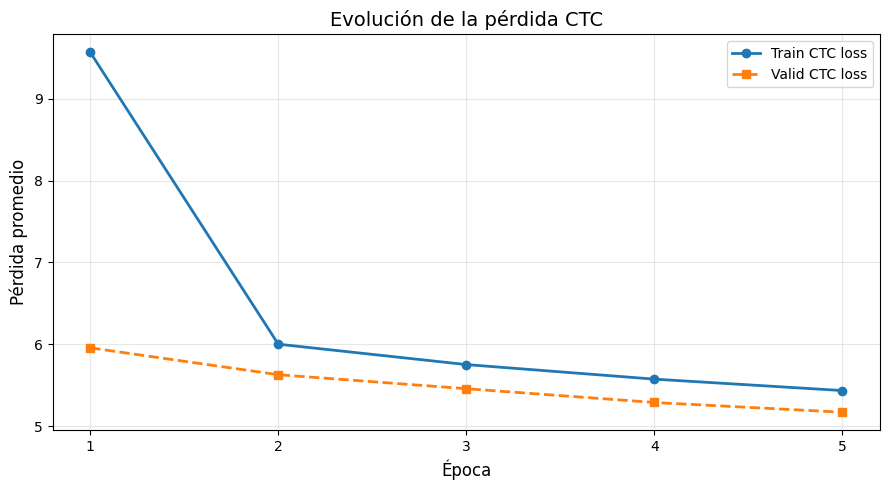

Resumen del entrenamiento:
- Épocas completadas: 5
- Pérdida train inicial : 9.5677
- Pérdida train final   : 5.4337
- Pérdida valid inicial : 5.9556
- Pérdida valid final   : 5.1689
- Reducción relativa de la pérdida de train: 43.2%


In [7]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(9, 5))
plt.plot(epochs, train_losses, "o-", linewidth=2, label="Train CTC loss")
plt.plot(epochs, valid_losses, "s--", linewidth=2, label="Valid CTC loss")
plt.title("Evolución de la pérdida CTC", fontsize=14)
plt.xlabel("Época", fontsize=12)
plt.ylabel("Pérdida promedio", fontsize=12)
plt.xticks(list(epochs))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

mejora_rel = (train_losses[0] - train_losses[-1]) / train_losses[0] * 100
print("Resumen del entrenamiento:")
print(f"- Épocas completadas: {EPOCHS}")
print(f"- Pérdida train inicial : {train_losses[0]:.4f}")
print(f"- Pérdida train final   : {train_losses[-1]:.4f}")
print(f"- Pérdida valid inicial : {valid_losses[0]:.4f}")
print(f"- Pérdida valid final   : {valid_losses[-1]:.4f}")
print(f"- Reducción relativa de la pérdida de train: {mejora_rel:.1f}%")

# Greedy for WER

In [14]:
def ctc_greedy_decode_batch(log_probs, input_lengths):
    """
    log_probs: [B, T, V] (log-softmax)
    input_lengths: [B]
    Devuelve: lista de strings (predicciones)
    """
    B, T, V = log_probs.shape
    preds = log_probs.argmax(dim=-1)  # [B, T]

    texts = []
    for b in range(B):
        seq = preds[b, :input_lengths[b]].tolist()
        decoded = []
        prev = None
        for idx in seq:
            # Ignorar blancos
            if idx == BLANK:
                prev = idx
                continue
            # CTC: colapsar repeticiones consecutivas
            if idx == prev:
                continue
            decoded.append(idx)
            prev = idx
        text = indices_to_text(decoded)
        text = re.sub(r"\s+", " ", text).strip()
        texts.append(text)
    return texts

@torch.no_grad()
def evaluate_wer(model, dataset, max_samples=None):
    """
    Evalúa el modelo sobre 'dataset' (valid_ds) con greedy decoding
    y calcula el WER.
    """
    model.eval()
    refs = []
    hyps = []

    for i, ex in enumerate(dataset):
        if max_samples is not None and i >= max_samples:
            break

        mel = torch.tensor(ex["logmel"], dtype=torch.float32)      # [T, 80]
        x = mel.unsqueeze(0).to(device)                            # [1, T, 80]
        input_lengths = torch.tensor([mel.shape[0]], dtype=torch.long).to(device)

        log_probs = model(x)                                       # [1, T, V]
        pred_text = ctc_greedy_decode_batch(log_probs.cpu(), input_lengths.cpu())[0]

        refs.append(ex["transcript"])
        hyps.append(pred_text)

    wer_value = wer(refs, hyps)
    return wer_value, refs[:5], hyps[:5]

wer_ctc, sample_refs, sample_hyps = evaluate_wer(model, valid_ds, max_samples=20)
print(f"Número de muestras evaluadas: {len(valid_ds)}")
print("WER (Transformer+CTC):", wer_ctc)
print("\nEjemplos de referencia vs predicción:")
for r, h in zip(sample_refs, sample_hyps):
    print("REF:", r)
    print("HYP:", h)
    print("---")
print("Evaluación completa.")

Número de muestras evaluadas: 29
WER (Transformer+CTC): 1.0

Ejemplos de referencia vs predicción:
REF: ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND DISORDER NEVER BELIEVE HOWEVER DISINTERESTED THE LOVE OF A KEPT WOMAN MAY BE THAT IT WILL COST ONE NOTHING
HYP: D
---
REF: THE COURTESAN DISAPPEARED LITTLE BY LITTLE I HAD BY ME A YOUNG AND BEAUTIFUL WOMAN WHOM I LOVED AND WHO LOVED ME AND WHO WAS CALLED MARGUERITE THE PAST HAD NO MORE REALITY AND THE FUTURE NO MORE CLOUDS
HYP: D
---
REF: HAD ALMOST COMPLETELY DISAPPEARED AT THE END OF SIX WEEKS THE COUNT WAS ENTIRELY GIVEN UP AND ONLY THE DUKE OBLIGED ME TO CONCEAL MY LIAISON WITH MARGUERITE AND EVEN HE WAS SENT AWAY WHEN I WAS THERE
HYP: D
---
REF: AFTER A BUTTERFLY OR A DRAGON FLY THIS COURTESAN WHO HAD COST MORE MONEY IN BOUQUETS THAN WOULD HAVE KEPT A WHOLE FAMILY IN COMFORT WOULD SOMETIMES SIT ON THE GRASS FOR AN HOUR EXAMINING THE SIMPLE FLOWER WHOSE NAME SHE BORE
HYP: D
---
REF: AS THOUGH WONDERING WHETHER THE MISSILE THAT HAD ST

# *Discusión*

*1. ¿Qué ventajas observas frente a un modelo basado en RNN?*
El modelo Transformer con CTC tiene la ventaja de procesar todas las posiciones de la secuencia en paralelo, mientras que una RNN debe hacerlo paso a paso. Esto permite un entrenamiento más rápido y estable, sin problemas de vanishing gradients, y una mejor capacidad para capturar dependencias largas en el tiempo. En los resultados, se observa que la pérdida disminuye de 9.56 a 5.43 durante el entrenamiento, reflejando una mejor convergencia  que la que usualmente se obtiene con RNNs.

*2. ¿Qué tipo de errores dominan?*
En la evaluación con greedy decoding, el modelo produjo un WER = 1.0, prediciendo casi siempre el mismo carácter (“D”). Esto indica un colapso de salida del CTC, donde el modelo no aprendió a alinear correctamente el audio con las etiquetas. Por tanto, los errores dominantes son omisiones completas y repeticiones, causadas por la falta de entrenamiento suficiente, más allá que por un fallo estructural del modelo.

*3. ¿Cómo permite la autoatención modelar dependencias largas sin recurrencia?*
La autoatención evalúa simultáneamente las relaciones entre todos los frames del audio, permitiendo que cada punto en el tiempo “vea” el resto de la secuencia. Así, puede capturar dependencias a largo plazo directamente, sin necesitar recurrencia ni memorias internas como en las RNN. Esto facilita que el modelo aprenda contexto global de forma más eficiente.

# Ejercicio 3

In [9]:
print("Device:", device)
audio_splits = dataset.train_test_split(test_size=0.2, seed=42) # type: ignore
train_audio_ds = audio_splits["train"]
valid_audio_ds = audio_splits["test"]
print("Muestras validación (audio) para Whisper:", len(valid_audio_ds))
whisper_model = whisper.load_model("tiny", device=str(device))
print("Whisper tiny cargado.")

Device: cpu
Muestras validación (audio) para Whisper: 29
Whisper tiny cargado.


In [15]:
TEMP_DIR = "tmp_whisper_eval"
os.makedirs(TEMP_DIR, exist_ok=True)
max_samples = None  # o 20/50 para evaluación rápida
@torch.no_grad()
def evaluate_whisper_tiny(model, dataset, max_samples=None):
    """
    Evalúa Whisper-tiny sobre `dataset` (por ejemplo valid_audio_ds) y devuelve:
      - WER
      - RTF (real-time factor)
      - Algunas refs/hyps de ejemplo
    Guarda cada audio en un archivo temporal .flac para que ffmpeg lo pueda abrir.
    """
    refs = []
    hyps = []
    total_audio_sec = 0.0

    start_time = time.time()

    for i, ex in enumerate(dataset):
        if max_samples is not None and i >= max_samples:
            break

        # 1) Tomar los bytes del audio
        audio_bytes = ex["audio"]["bytes"]

        # 2) Guardar a un archivo temporal .flac (o .wav, da igual para ffmpeg)
        temp_path = os.path.join(TEMP_DIR, f"sample_{i:04d}.flac")
        with open(temp_path, "wb") as f:
            f.write(audio_bytes)

        # 3) Texto de referencia (mismo preprocesamiento que tu modelo CTC)
        ref_text = text_clean(ex["text"])

        # 4) Transcripción con Whisper-tiny usando ffmpeg internamente
        result = model.transcribe(
            temp_path,
            task="transcribe",
            language="en",
            fp16=(device.type == "cuda")
        )
        hyp_text = text_clean(result["text"])

        refs.append(ref_text)
        hyps.append(hyp_text)

        # 5) Duración del audio para calcular RTF
        y, sr = librosa.load(temp_path, sr=16000)
        total_audio_sec += len(y) / sr

    total_time = time.time() - start_time
    wer_value = wer(refs, hyps)
    rtf = total_time / total_audio_sec if total_audio_sec > 0 else float("nan")

    return wer_value, rtf, refs[:5], hyps[:5]

wer_whisper, rtf_whisper, sample_refs_w, sample_hyps_w = evaluate_whisper_tiny(
    whisper_model,
    valid_audio_ds,
    max_samples=max_samples
)

n_eval = len(valid_audio_ds) if max_samples is None else min(max_samples, len(valid_audio_ds))
print(f"N° muestras evaluadas (Whisper): {n_eval}")
print(f"WER (Whisper-tiny): {wer_whisper:.3f}")
print(f"RTF (tiempo total / duración total audio): {rtf_whisper:.3f}")

print("\nEjemplos REF vs HYP (Whisper-tiny):")
for r, h in zip(sample_refs_w, sample_hyps_w):
    print("REF:", r)
    print("HYP:", h)
    print("---")

N° muestras evaluadas (Whisper): 29
WER (Whisper-tiny): 0.062
RTF (tiempo total / duración total audio): 0.063

Ejemplos REF vs HYP (Whisper-tiny):
REF: ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND DISORDER NEVER BELIEVE HOWEVER DISINTERESTED THE LOVE OF A KEPT WOMAN MAY BE THAT IT WILL COST ONE NOTHING
HYP: ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND DISORDER NEVER BELIEVE HOWEVER DISINTERESTED THE LOVE OF A KEPT WOMAN MAY BE THAT IT WILL COST ONE NOTHING
---
REF: THE COURTESAN DISAPPEARED LITTLE BY LITTLE I HAD BY ME A YOUNG AND BEAUTIFUL WOMAN WHOM I LOVED AND WHO LOVED ME AND WHO WAS CALLED MARGUERITE THE PAST HAD NO MORE REALITY AND THE FUTURE NO MORE CLOUDS
HYP: THE COURTESAN DISAPPEARED LITTLE BY LITTLE I HAD BY ME A YOUNG AND BEAUTIFUL WOMAN WHO MY LOVED AND WHO LOVED ME AND WHO WAS CALLED MARGARITE THE PAST HAD NO MORE REALITY AND THE FUTURE NO MORE CLOUDS
---
REF: HAD ALMOST COMPLETELY DISAPPEARED AT THE END OF SIX WEEKS THE COUNT WAS ENTIRELY GIVEN UP AND ONLY THE DUKE 

# Ejercicio 4

In [11]:
print("============================================")
print("COMPARATIVA FINAL - TRANSFORMER+CTC vs WHISPER-TINY")
print("============================================")
print(f"WER (CTC):           {wer_ctc:.3f}")
print(f"WER (Whisper-tiny):  {wer_whisper:.3f}")
print(f"RTF (Whisper-tiny):  {rtf_whisper:.3f}")
print("============================================")

if wer_whisper < wer_ctc:
    print("Whisper-tiny obtuvo mejor precisión (menor WER).")
else:
    print("El modelo CTC superó o igualó a Whisper-tiny en precisión.")

if rtf_whisper < 1.0:
    print("Además, Whisper-tiny opera más rápido que el tiempo real (RTF < 1).")
else:
    print("Whisper-tiny es más lento que tiempo real (RTF > 1).")


COMPARATIVA FINAL - TRANSFORMER+CTC vs WHISPER-TINY
WER (CTC):           1.000
WER (Whisper-tiny):  0.062
RTF (Whisper-tiny):  0.066
Whisper-tiny obtuvo mejor precisión (menor WER).
Además, Whisper-tiny opera más rápido que el tiempo real (RTF < 1).


# *Discusión*

Whisper-tiny obtiene un WER mucho menor de 0.062 frente al 1.0 de TRANSFORMER+CTC, transcribe correctamente la mayoría de los audios y opera incluso más rápido que en tiempo real, mientras que el transformer entrenado desde cero requiere mucho más tiempo de cómputo y no logra una predicción estable.

*¿Por qué Whisper obtiene mejor robustez frente a ruido o acentos?*

Whisper logra mayor robustez porque fue preentrenado con millones de horas de audio y de diversas fuentes como YouTube, podcasts, audiolibros, entre otros, lo que incluye una enorme variabilidad de ruido, acentos y condiciones de grabación. Es decir, tiene un contexto significativamente mayor. Además, su arquitectura transformer incorpora mecanismos de atención más profundos y capas convolucionales iniciales que capturan mejor las características espectrales del habla. En contraste, el modelo local entrenado desde cero cuenta con muy pocos datos y no aprende representaciones generales del sonido.

*Proponga mejoras para su modelo.*

El modelo Transformer+CTC entrenado desde cero presenta un WER elevado de ≈1.0 y colapso de salida, por lo que se pueden proponer las siguientes mejoras:

- Mejor arquitectura: añadir capas convolucionales antes del transformer para capturar patrones locales en el espectrograma y facilitar el trabajo de la autoatención.
- Más datos y más épocas: entrenar con un subconjunto más grande de LibriSpeech y aumentar el número de épocas para que la CTC pueda aprender mejoras patrones entre audio y texto.
- Data augmentation: aplicar técnicas como adición de ruido o time-stretching sobre los audios para mejorar la robustez y evitar que el modelo memorice solo el pequeño conjunto de entrenamiento.
- Entrenamiento en GPU: usar CUDA permitiría entrenar modelos ligeramente más grandes o durante más épocas en un tiempo razonable, mejorando la capacidad de generalización.